In [1]:
from stable_baselines3 import DQN
import torch

/Users/amalota/anaconda3/envs/py37_trainloop/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path

['/Users/amalota/Documents/trainloop-driver/analysis',
 '/Users/amalota/anaconda3/envs/py37/lib/python37.zip',
 '/Users/amalota/anaconda3/envs/py37/lib/python3.7',
 '/Users/amalota/anaconda3/envs/py37/lib/python3.7/lib-dynload',
 '',
 '/Users/amalota/anaconda3/envs/py37/lib/python3.7/site-packages',
 '/Users/amalota/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/extensions',
 '/Users/amalota/.ipython']

In [3]:
import os
os.getcwd()

'/Users/amalota/Documents/trainloop-driver/analysis'

In [2]:
import sys
sys.path.append(os.getcwd()+'/src/')
%load_ext autoreload
%autoreload 2

In [5]:
# model = DQN.load('../output_models/2021-06-18_16_57_43_15.zip')
# model.load_replay_buffer("../output_models/2021-06-18_16_57_43_15_rb")

In [36]:
model = DQN.load('../best_model/dqn/MlpPolicy/best_model.zip')
model.load_replay_buffer("../best_model/dqn/MlpPolicy/best_model_rb")

In [20]:
net = model.q_net
net.eval()

QNetwork(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (q_net): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [37]:
model.replay_buffer.observations.shape

(1000000, 1, 7)

In [38]:
X = model.replay_buffer.observations[0:100]
X = torch.Tensor(X)
# X = torch.squeeze(X, 1)
X.shape

torch.Size([100, 1, 7])

In [23]:
X.sum()

tensor(60.0307)

In [42]:
C = np.load('../best_model/dqn/MlpPolicy/observations.npy')
C = torch.Tensor(C)
C.shape

torch.Size([12, 1, 7])

In [15]:
X.shape

torch.Size([100, 1, 1, 30, 7])

In [24]:
from captum.attr import IntegratedGradients
import numpy as np
import sys

In [28]:
from utils import Utils
from attribute import IGAttributor
from plot import plot_mean_attributions
action_names = Utils.ACTION_NAMES
feature_names = Utils.FEATURE_NAMES

In [39]:
ig_attributor = IGAttributor(model=model)
mean_attributions = ig_attributor.get_mean_attributions()

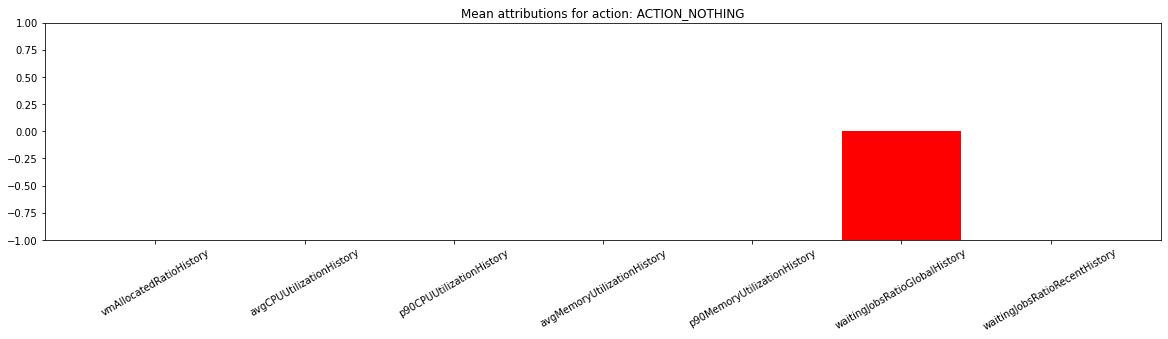

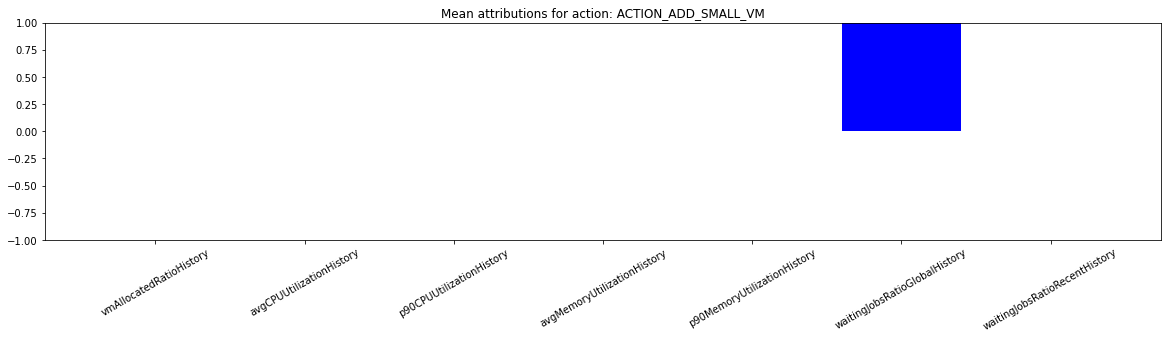

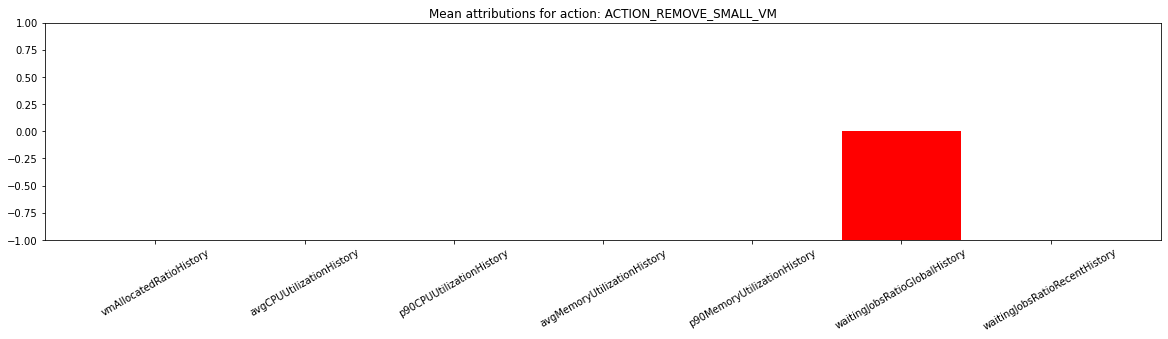

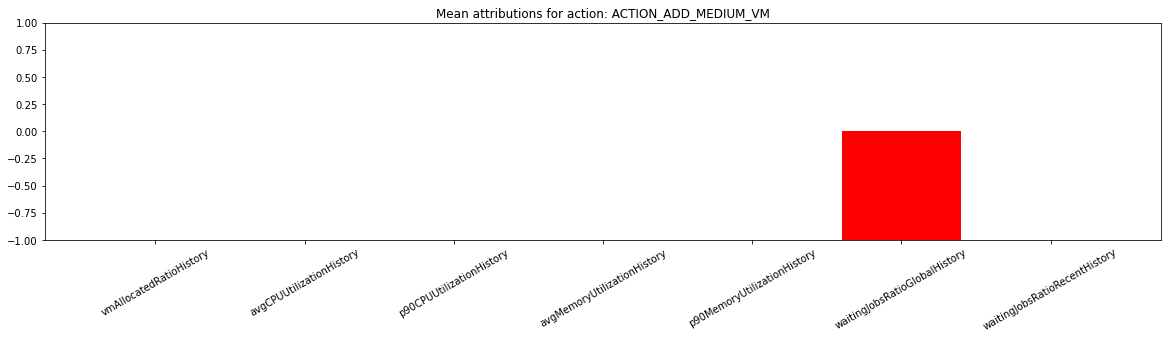

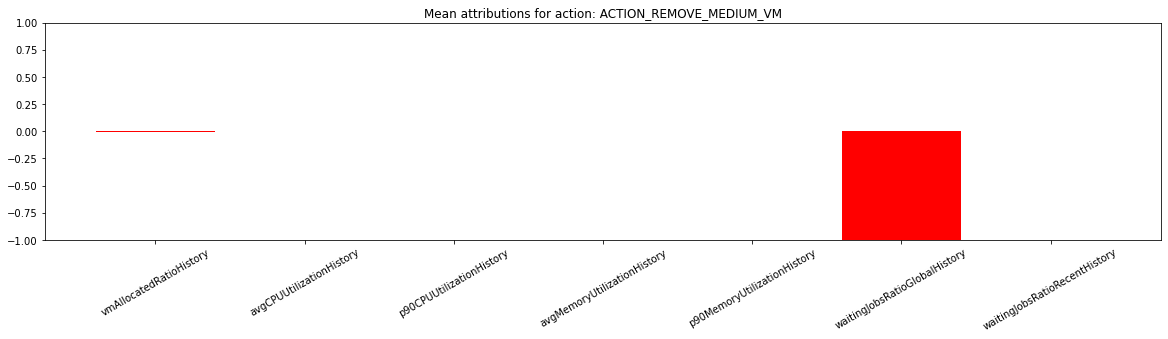

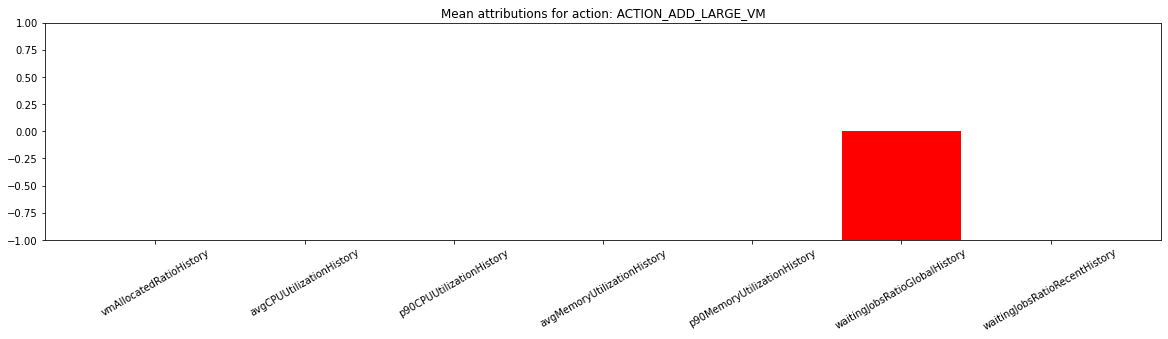

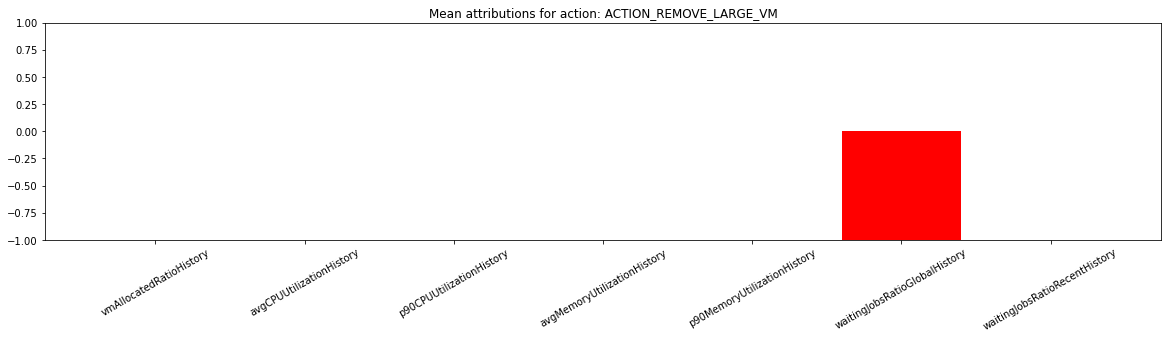

In [40]:
plot_mean_attributions(mean_attributions=mean_attributions)

In [43]:
x_axis_data = np.arange(X.shape[2])

ig = IntegratedGradients(net)

ig_attr_per_action = [ig.attribute(X, n_steps=50, target=target) for target in range(len(feature_names))]
ig_attr_test_norm_sum = [action_att.detach().numpy().sum(0) / np.linalg.norm(action_att.detach().numpy().sum(0), ord=1) for action_att in ig_attr_per_action]

In [13]:

ig_attr_test_norm_sum = [action_att.detach().numpy().sum(0) / np.linalg.norm(action_att.detach().numpy().sum(0), ord=1) for action_att in ig_attr_per_action]

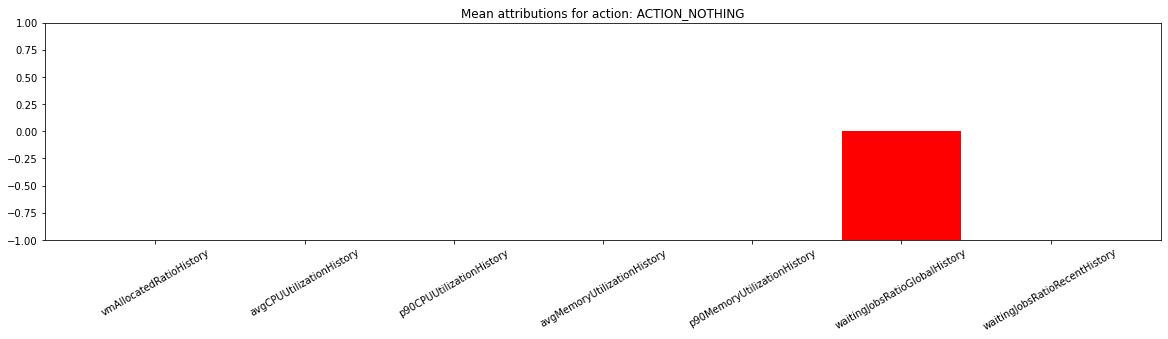

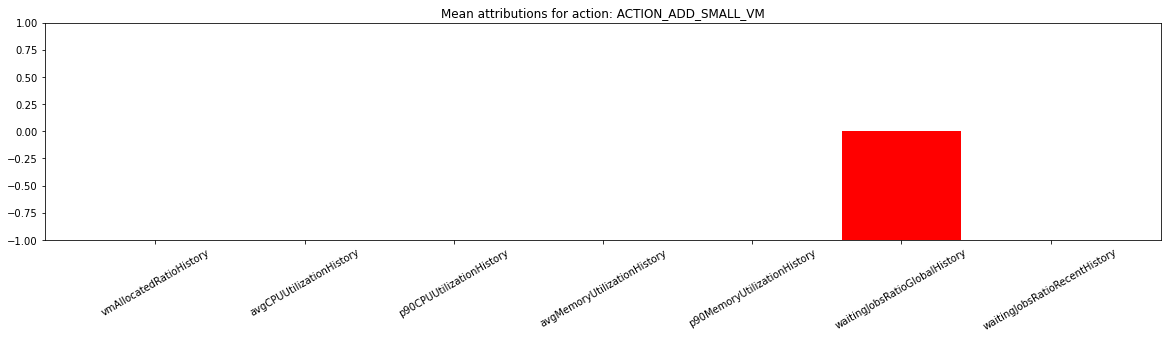

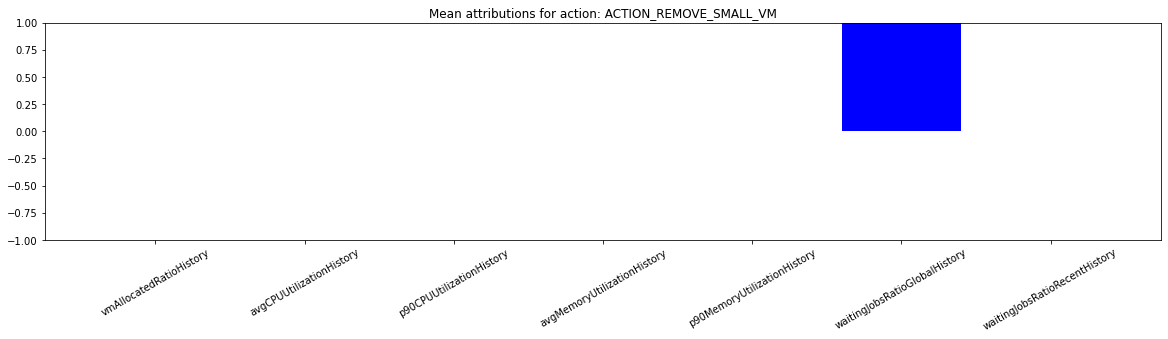

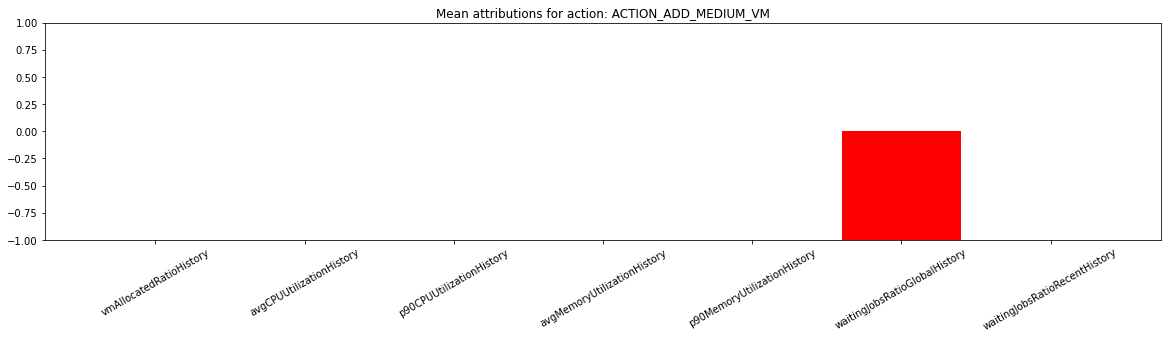

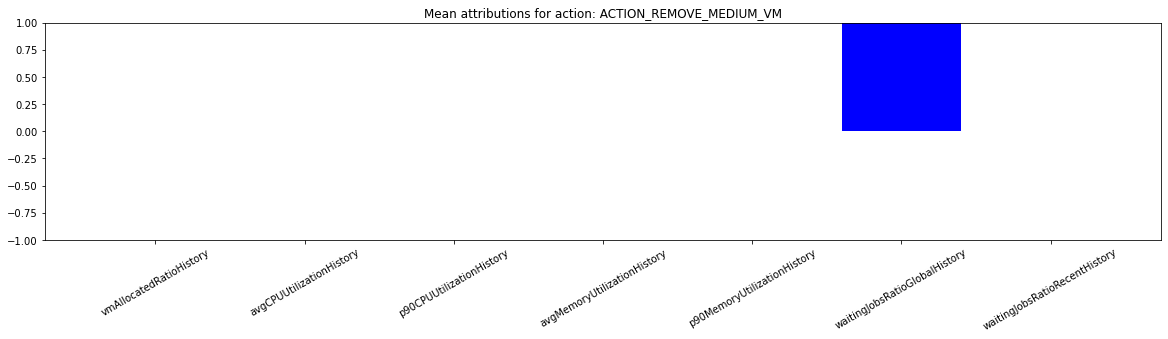

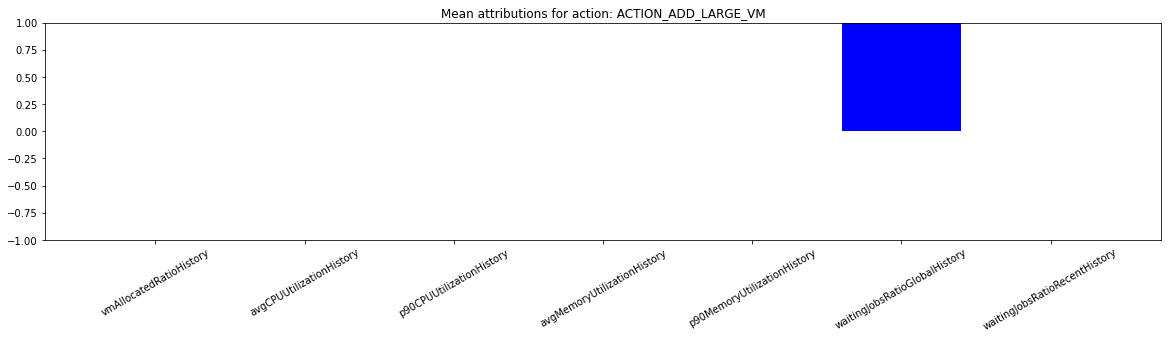

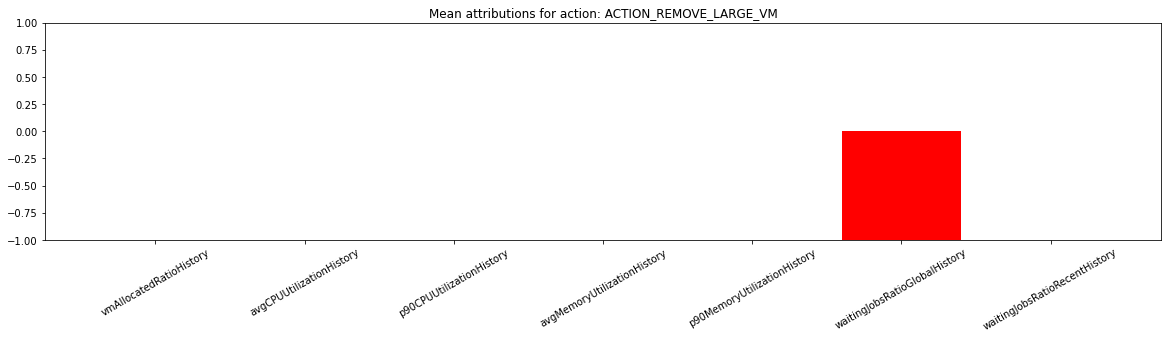

In [44]:
import matplotlib.pyplot as plt

for i, ig_attr in enumerate(ig_attr_test_norm_sum):
    plt.figure(figsize=(20, 4))
    plt.title(f'Mean attributions for action: {action_names[i]}')
    plt.xticks(x_axis_data, feature_names, rotation=30)
    plt.ylim([-1, 1])
    col = []
    for val in ig_attr[0]:
        if val < 0.0:
            col.append('red')
        else:
            col.append('blue')
    plt.bar(x_axis_data, ig_attr[0], color=col)

In [47]:
def render_env(img, feature_names):
    plt.figure(figsize=(20, 4))
    col = []
    for val in img:
        if val < 0.0:
            col.append('red')
        else:
            col.append('blue')
    plt.xticks(range(7), feature_names, rotation=30)
    plt.bar(range(7), img, color=col)
    plt.title('Environment state')
    plt.show()

In [45]:
def explain_action(idx, X, attributions, x_axis_data, feature_names, action_names, model, state=None):
    img = X[idx][0].numpy()
    q_values = model.q_net.forward(X[idx]).detach().numpy()
    action = np.argmax(q_values)
    
    print(f'Action made: {action_names[action]}')
    
    render_env(img=img,
           feature_names=feature_names)
    
    fig, axs = plt.subplots(len(attributions), 1, figsize=(20, 20), sharex=True)
    plt.xticks(x_axis_data, feature_names, rotation=30)
    for i, ig_attr in enumerate(attributions):
        axs[i].set_title(f'Attributions for action: {action_names[i]}')
        col = []
        ig_attr = ig_attr.numpy()[idx][0]
        for val in ig_attr:
            if val < 0.0:
                col.append('red')
            else:
                col.append('blue')
        axs[i].bar(x_axis_data, ig_attr, color=col)
    


Action made: ACTION_REMOVE_SMALL_VM


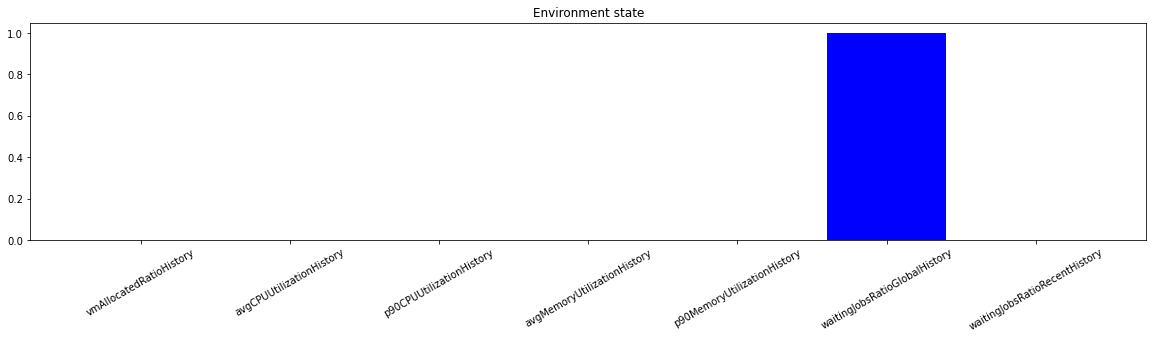

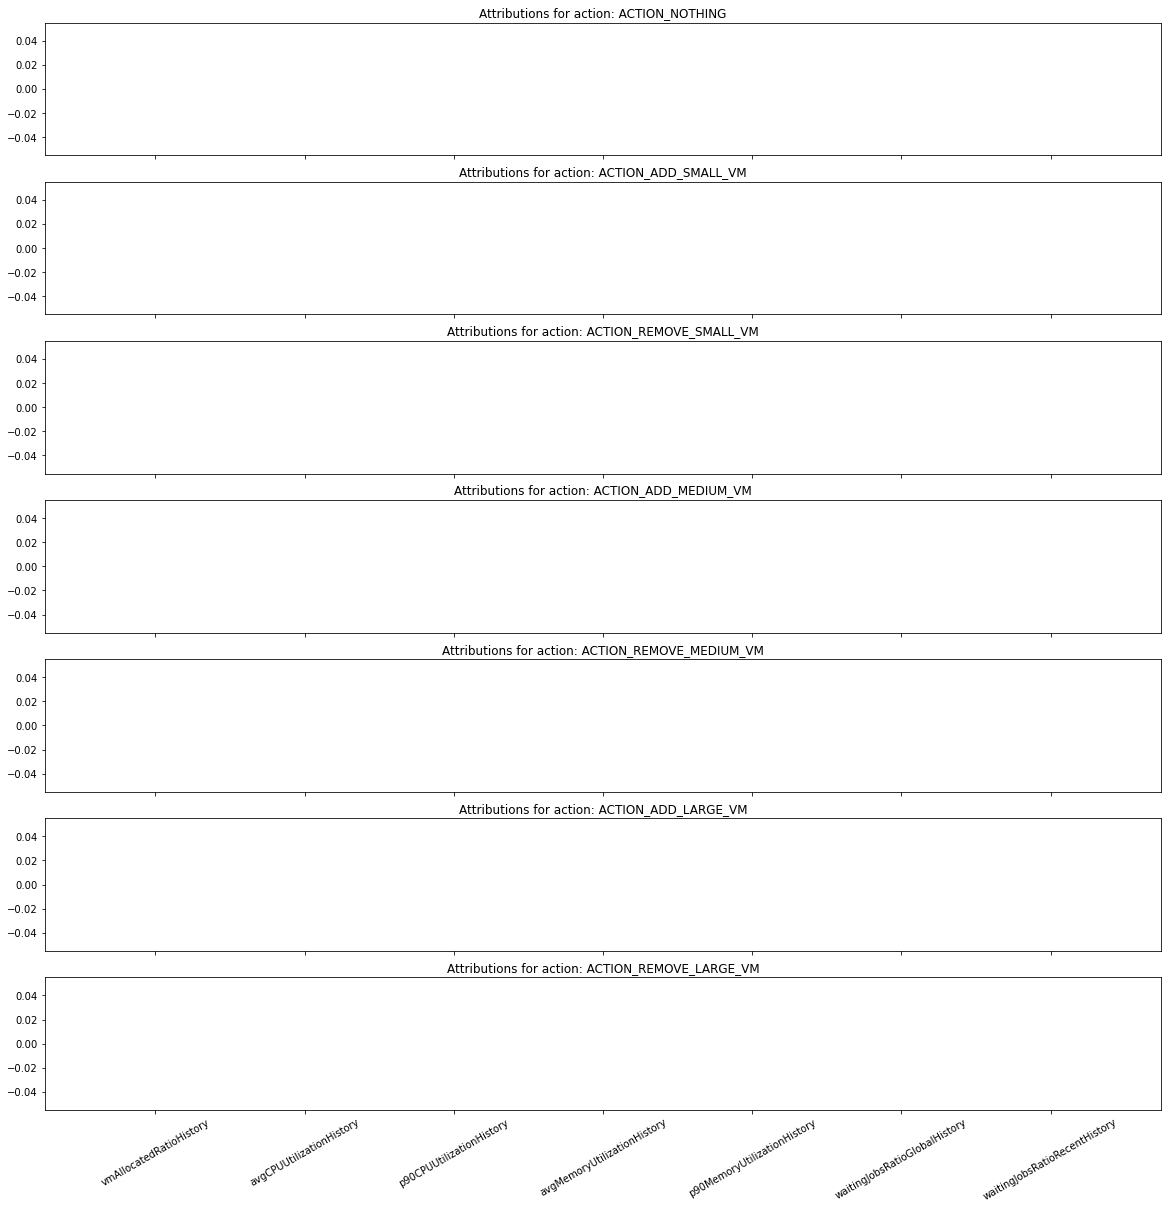

In [52]:
explain_action(idx=10,
               X=C,
               attributions=ig_attr_per_action,
               x_axis_data=x_axis_data,
               feature_names=feature_names,
               action_names=action_names,
               model=model,
              )

In [59]:
X_manual = torch.Tensor([[[1, 1, 1, 1, 1, 1, 1]]])

In [54]:
X_manual = torch.Tensor([[[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]]])

In [127]:
X_manual = torch.Tensor([[[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]])

In [124]:
X_manual.shape

torch.Size([1, 1, 7])

In [55]:
x_axis_data = np.arange(X_manual.shape[2])

ig = IntegratedGradients(net)

ig_attr_per_action = [ig.attribute(X_manual, n_steps=50, target=target) for target in range(len(action_names))]
ig_attr_test_norm_sum = [action_att.detach().numpy().sum(0) / np.linalg.norm(action_att.detach().numpy().sum(0), ord=1) for action_att in ig_attr_per_action]

Action made: ACTION_ADD_MEDIUM_VM


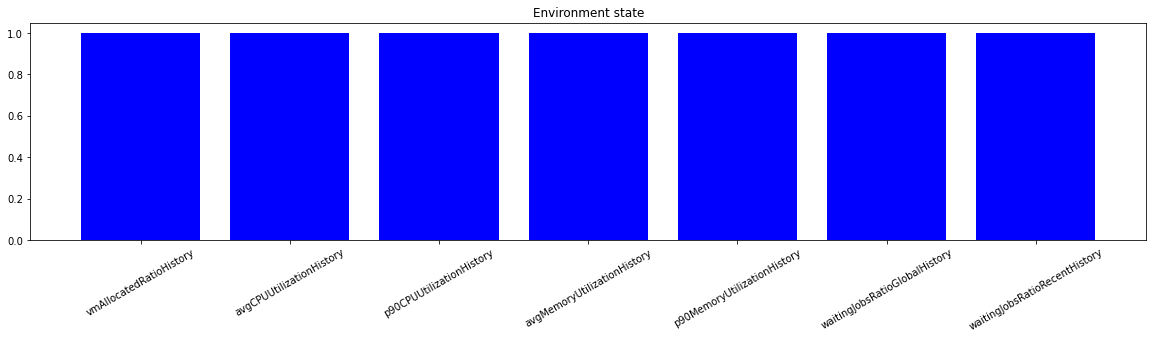

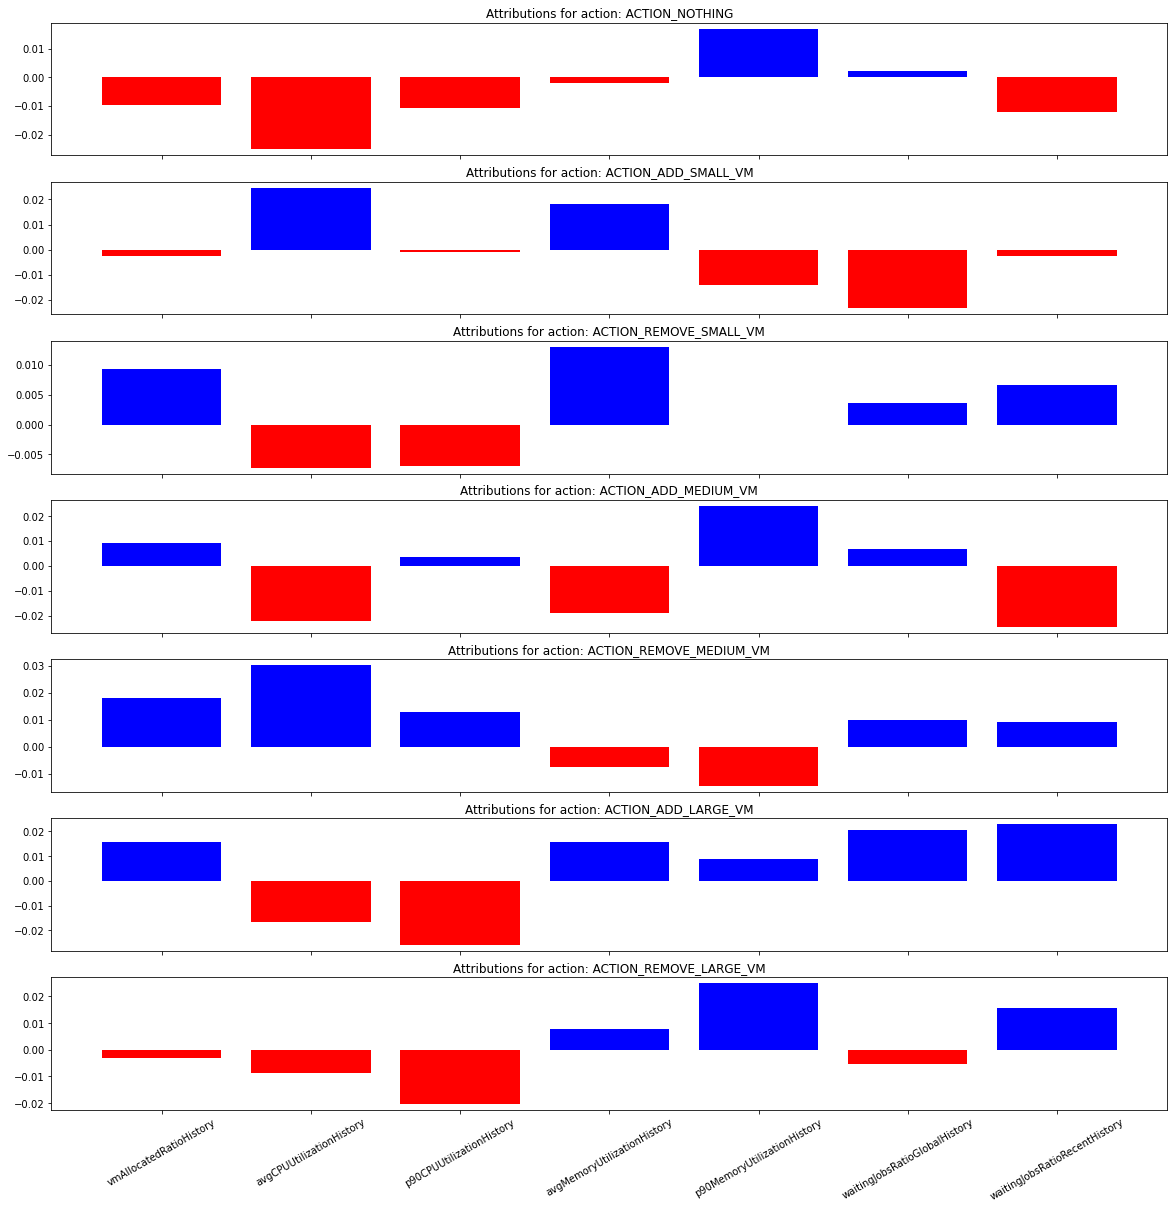

In [60]:
explain_action(idx=0,
               X=X_manual,
               attributions=ig_attr_per_action,
               x_axis_data=x_axis_data,
               feature_names=feature_names,
               action_names=action_names,
               model=model,
              )